In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = (8,6)
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [2]:
def newline(p1, p2, color=None): # функция отрисовки линии
    #function kredits to: https://fooobar.com/questions/626491/how-to-draw-a-line-with-matplotlib
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color=color)
    ax.add_line(l)
    return l

In [3]:
def add_bias_feature(a):
    a_extended = np.zeros((a.shape[0],a.shape[1]+1))
    a_extended[:,:-1] = a
    a_extended[:,-1] = int(1)  
    return a_extended

class CustomSVM(object):

    __class__ = "CustomSVM"
    __doc__ = """
    This is an implementation of the SVM classification algorithm
    Note that it works only for binary classification

    #############################################################
    ######################   PARAMETERS    ######################
    #############################################################

    etha: float(default - 0.01)
        Learning rate, gradient step

    alpha: float, (default - 0.1)
        Regularization parameter in 0.5*alpha*||w||^2

    epochs: int, (default - 200)
        Number of epochs of training

    #############################################################
    #############################################################
    #############################################################
    """

    def __init__(self, etha=0.01, alpha=0.1, epochs=200):
        self._epochs = epochs
        self._etha = etha
        self._alpha = alpha
        self._w = None
        self.history_w = []
        self.train_errors = None
        self.val_errors = None
        self.train_loss = None
        self.val_loss = None

    def fit(self, X_train, Y_train, X_val, Y_val, verbose=False): #arrays: X; Y =-1,1

        if len(set(Y_train)) != 2 or len(set(Y_val)) != 2:
            raise ValueError("Number of classes in Y is not equal 2!")

        X_train = add_bias_feature(X_train) 
        X_val = add_bias_feature(X_val)
        self._w = np.random.normal(loc=0, scale=0.05, size=X_train.shape[1])
        self.history_w.append(self._w)
        train_errors = []
        val_errors = []
        train_loss_epoch = []
        val_loss_epoch = []

        for epoch in range(self._epochs): 
            tr_err = 0
            val_err = 0
            tr_loss = 0
            val_loss = 0
            for i,x in enumerate(X_train): # Y(W*X+b)>=1
                margin = Y_train[i]*np.dot(self._w,X_train[i])
                if margin >= 1: # классифицируем верно
                    self._w = self._w - self._etha*self._alpha*self._w/self._epochs
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                else: # классифицируем неверно или попадаем на полосу разделения при 0<m<1
                    self._w = self._w +\
                    self._etha*(Y_train[i]*X_train[i] - self._alpha*self._w/self._epochs)
                    tr_err += 1
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                self.history_w.append(self._w)
            for i,x in enumerate(X_val):
                val_loss += self.soft_margin_loss(X_val[i], Y_val[i])
                val_err += (Y_val[i]*np.dot(self._w,X_val[i])<1).astype(int)
            if verbose:
                print('epoch {}. Errors={}. Mean Hinge_loss={}'\
                      .format(epoch,err,loss))
            train_errors.append(tr_err)
            val_errors.append(val_err)
            train_loss_epoch.append(tr_loss)
            val_loss_epoch.append(val_loss)
        self.history_w = np.array(self.history_w)    
        self.train_errors = np.array(train_errors)
        self.val_errors = np.array(val_errors)
        self.train_loss = np.array(train_loss_epoch)
        self.val_loss = np.array(val_loss_epoch)                    

    def predict(self, X:np.array) -> np.array:
        y_pred = []
        X_extended = add_bias_feature(X)
        for i in range(len(X_extended)):
            y_pred.append(np.sign(np.dot(self._w,X_extended[i])))
        return np.array(y_pred)         

    def hinge_loss(self, x, y):
        return max(0,1 - y*np.dot(x, self._w))

    def soft_margin_loss(self, x, y):
        return self.hinge_loss(x,y)+self._alpha*np.dot(self._w, self._w)

In [4]:
iris = load_iris()
X = iris.data
Y = iris.target

pca = PCA(n_components=2)
X = pca.fit_transform(X)
Y = (Y > 0).astype(int)*2-1 # [0,1,2] --> [False,True,True] --> [0,1,1] --> [0,2,2] --> [-1,1,1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=2020)

[65 31 23 18 15 14 13 10  8  8  5  5  6  5  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  3  3  3  3  3  1  2  1  2  1  2  1  2  1  2  1
  2  1  2  1  2  1  2  1  2  1  1  2  1  2  1  2  1  2  1  2  1  2  1  2
  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  2  1  1  2  1  2  1  2  1
  2  1  2  1  2  1  2  1  2  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
[ 0.95762665 -0.86883288  1.21410976]


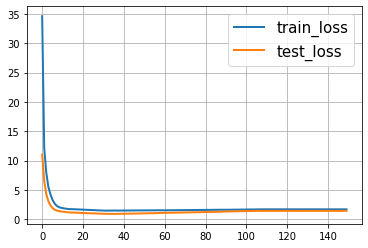

In [5]:
svm = CustomSVM(etha=0.005, alpha=0.006, epochs=150)
svm.fit(X_train, Y_train, X_test, Y_test)

print(svm.train_errors) # numbers of error in each epoch
print(svm._w) # w0*x_i[0]+w1*x_i[1]+w2=0

plt.plot(svm.train_loss, linewidth=2, label='train_loss')
plt.plot(svm.val_loss, linewidth=2, label='test_loss')
plt.grid()
plt.legend(prop={'size': 15})
plt.show()

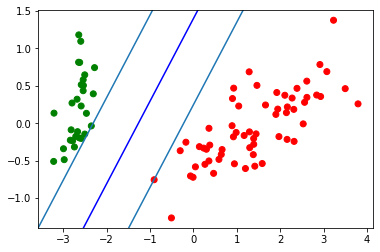

In [6]:
d = {-1:'green', 1:'red'}
plt.scatter(X_train[:,0], X_train[:,1], c=[d[y] for y in Y_train])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue') # в w0*x_i[0]+w1*x_i[1]+w2*1=0 поочередно
                                                        # подставляем x_i[0]=0, x_i[1]=0
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from mlxtend.plotting import plot_decision_regions

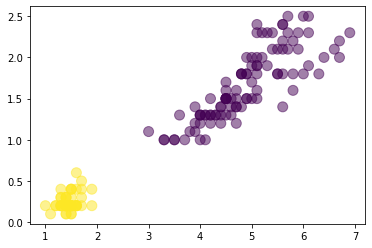

In [8]:
iris = datasets.load_iris()

X = iris["data"][:, (2, 3)]  # выбираем 2 признака

y = (iris["target"] == 0).astype(np.int32)  # будем учить класс с меткой 2

plt.scatter(X[:,0], X[:,1], s=100, c=y, alpha=0.5)
plt.show()

Линейный SVM

In [9]:
svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge")),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge'))])

In [10]:
svm_clf.predict([[4.4, 2.1]])

array([0], dtype=int32)

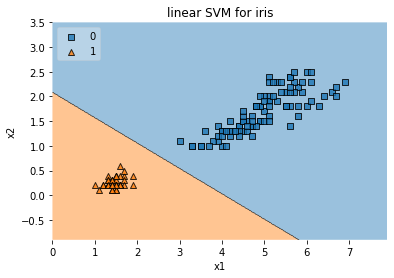

In [11]:
plot_decision_regions(X, y, clf=svm_clf, legend=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('linear SVM for iris')
plt.show()

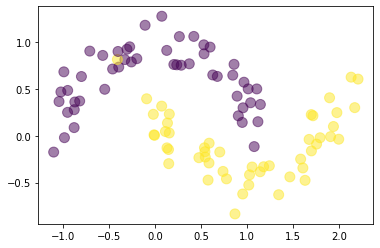

In [12]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)
plt.scatter(X[:,0], X[:,1], s=100, c=y, alpha=0.5)
plt.show()

In [13]:
polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=100, loss="hinge"))
    ])

polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=100, loss='hinge'))])

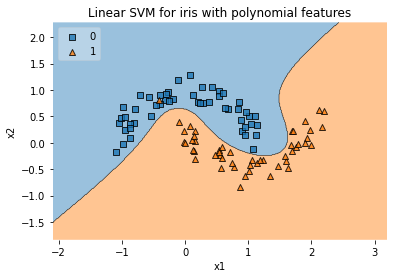

In [14]:
plot_decision_regions(X, y, clf=polynomial_svm_clf, legend=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Linear SVM for iris with polynomial features')
plt.show()

Ядерные SVM (SVM с ядром)

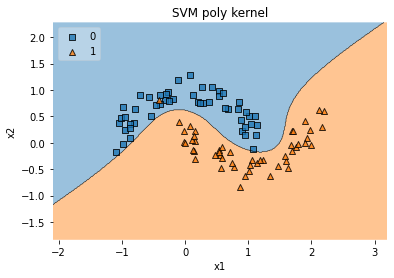

In [15]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=10))
    ])

poly_kernel_svm_clf.fit(X, y)

plot_decision_regions(X, y, clf=poly_kernel_svm_clf, legend=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SVM poly kernel')
plt.show()

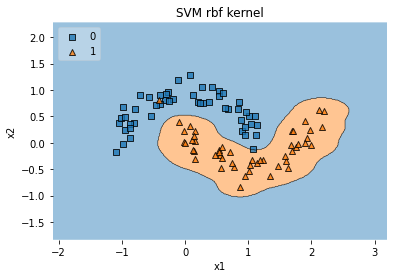

In [16]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=8, C=.10))
    ])

rbf_kernel_svm_clf.fit(X, y)

plot_decision_regions(X, y, clf=rbf_kernel_svm_clf, legend=2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('SVM rbf kernel')
plt.show()

Регрессия с помощью SVM

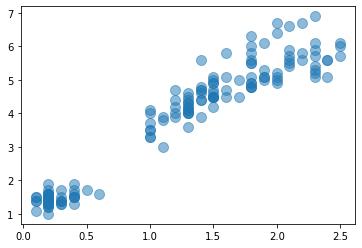

In [17]:
iris = datasets.load_iris()

X = iris["data"][:, (3)] 

y = iris["data"][:, (2)] 

plt.scatter(X, y, s=100, alpha=0.5)
plt.show()

In [18]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=0.5)

svm_reg.fit(X.reshape(-1,1),y)

LinearSVR(epsilon=0.5)